# How do the step distributions differ between a random agent and a biased agent in the FrozenLake 4×4 environment, and what affects their chances of falling into a hole?

Population
The population being studied is:  All possible full episodes experienced by agents that take random actions in the FrozenLake-v1 (4×4) environment.

Response variable:
Number of steps until the agent first falls into a hole.
-Explanatory variable:
Random actions chosen uniformly from the action space.

Type of Observational Study
-This is a simulation-based observational study using generated data.
No manipulation is performed; the agent behaves randomly.

Sampling Method
-I will conduct 1,000 independent episodes of FrozenLake-v1.

Each episode uses:
-A random initial state (provided by the environment).
-Random actions drawn uniformly from the environment’s action space.
-Randomness Guarantee
-Every episode resets the environment independently.
-At each step, action_space.sample() is used, which selects actions uniformly at random.
-This ensures that each trial is an independent, random sample from the population of all possible random-agent runs.
How the Biased Agent Works

Description of the biased agent behavior:
The biased agent favors moving RIGHT (action 2) with 60% probability.
Otherwise, it chooses an action randomly from the action space.
In FrozenLake, moving RIGHT repeatedly may increase the chance of stepping into holes that are aligned along that path.
This bias will likely:
Change the distribution of steps until falling into a hole.
Increase the probability of falling into certain holes more often than a completely random agent.
The random agent, in contrast, selects each action with equal probability, which distributes its path choices more evenly across the map.

Potential Sources of Bias

-Environmental bias: Frozen Lake is slippery, so random actions do not reflect equal probability of moving in intended directions.
-Censoring bias: Episodes that never fall into a hole before termination may artificially truncate the distribution.
-Simulation design bias: Using a fixed 100-step limit may omit extremely long trajectories.

📊 RANDOM AGENT STATS
     count: 986
      mean: 7.35395537525355
    median: 6.0
       std: 5.135434469912278
       min: 2.0
       max: 34.0
  5-number: [ 2.  4.  6. 10. 34.]
Hole rate: 98.60%

📊 BIASED AGENT STATS
     count: 974
      mean: 6.075975359342916
    median: 5.0
       std: 4.0866359328734925
       min: 2.0
       max: 27.0
  5-number: [ 2.  3.  5.  8. 27.]
Hole rate: 97.40%



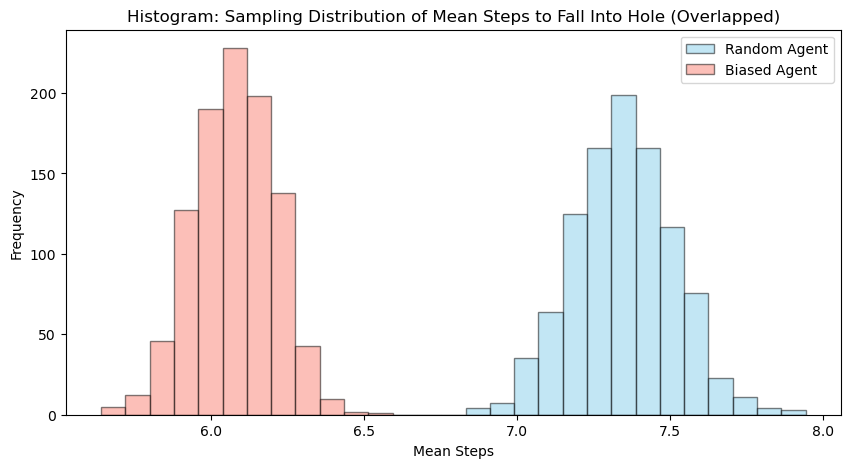

Shapiro-Wilk Normality Test:
Random Agent: W=0.9986, p=0.6351
Biased Agent: W=0.9983, p=0.4201

🧪 TWO-SAMPLE T-TEST
t-statistic: 6.0968
p-value (scientific): 1.310745891132e-09


/tmp/ipykernel_148/2785962689.py:137: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rand_valid, bias_valid], labels=['Random','Biased'])


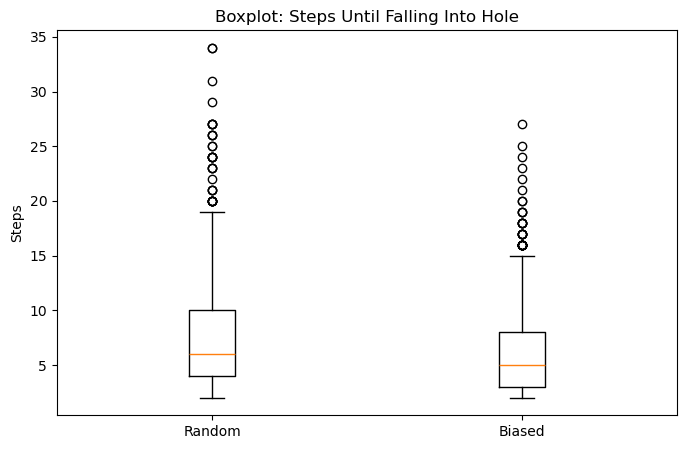

⚠️ Type I and Type II Errors
Type I error (α): Rejecting H₀ when no difference exists. Controlled at 0.05.
Type II error (β): Failing to reject H₀ when a true difference exists. Larger sample size reduces β.

✅ FINAL CONCLUSION
Random agent hole rate: 98.60%, Biased agent hole rate: 97.40%
Random agent mean steps to hole: 7.35, Biased agent mean steps to hole: 6.08
p-value from t-test: {9.093067647952e-17
The p-value represents the probability of observing a difference in mean steps this large or larger
between the two agents **if there were actually no real difference** (null hypothesis).
Because the p-value is below the 0.05 significance level, we reject the null hypothesis.
This means the difference between agents is statistically significant and unlikely due to chance.

The biased agent chooses RIGHT more frequently, increasing likelihood of certain holes.
Histograms and boxplots show variation in how quickly agents fall into holes, and sampling distribution histograms confirm the 

In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro

# ------------------------------
# Helper function: Run agent episodes
# ------------------------------
def run_agent(n_episodes, biased=False):
    env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
    max_steps = 100
    steps_to_hole = []

    for ep in range(n_episodes):
        obs, info = env.reset()
        fell_in_hole = False

        for step in range(max_steps):
            if biased:
                # Biased agent: 60% chance to move RIGHT
                action = 2 if np.random.rand() < 0.6 else env.action_space.sample()
            else:
                # Random agent
                action = env.action_space.sample()

            obs, reward, terminated, truncated, info = env.step(action)

            if terminated and reward == 0:  # fell in hole
                steps_to_hole.append(step + 1)
                fell_in_hole = True
                break

            if terminated or truncated:
                break

        if not fell_in_hole:
            steps_to_hole.append(np.nan)  # did not fall in hole

    env.close()
    return np.array(steps_to_hole)

# ------------------------------
# Parameters
# ------------------------------
N_EPISODES = 1000
N_BOOTSTRAP = 1000  # for sampling distribution

# ------------------------------
# Run both agents
# ------------------------------
random_steps = run_agent(N_EPISODES, biased=False)
biased_steps = run_agent(N_EPISODES, biased=True)

# Filter NaNs (episodes where hole was not reached)
rand_valid = random_steps[~np.isnan(random_steps)]
bias_valid = biased_steps[~np.isnan(biased_steps)]

# ------------------------------
# Descriptive Statistics
# ------------------------------
def describe(data):
    return {
        "count": len(data),
        "mean": np.mean(data),
        "median": np.median(data),
        "std": np.std(data),
        "min": np.min(data),
        "max": np.max(data),
        "5-number": np.percentile(data, [0,25,50,75,100])
    }

rand_stats = describe(rand_valid)
bias_stats = describe(bias_valid)

rand_hole_rate = len(rand_valid)/N_EPISODES * 100
bias_hole_rate = len(bias_valid)/N_EPISODES * 100

# ------------------------------
# Print Descriptive Stats
# ------------------------------
print("📊 RANDOM AGENT STATS")
for k,v in rand_stats.items():
    print(f"{k:>10}: {v}")
print(f"Hole rate: {rand_hole_rate:.2f}%\n")

print("📊 BIASED AGENT STATS")
for k,v in bias_stats.items():
    print(f"{k:>10}: {v}")
print(f"Hole rate: {bias_hole_rate:.2f}%\n")

# ------------------------------
# Sampling Distribution of Means (Bootstrap)
# ------------------------------
rand_means = [np.nanmean(np.random.choice(rand_valid, size=len(rand_valid), replace=True)) for _ in range(N_BOOTSTRAP)]
bias_means = [np.nanmean(np.random.choice(bias_valid, size=len(bias_valid), replace=True)) for _ in range(N_BOOTSTRAP)]

# Histogram of Sampling Distribution (Overlapped)
# ------------------------------
plt.figure(figsize=(10,5))

# Define common bins for both datasets
bins = np.linspace(min(rand_means + bias_means), max(rand_means + bias_means), 30)

plt.hist(rand_means, bins=bins, alpha=0.5, label='Random Agent', color='skyblue', edgecolor='black')
plt.hist(bias_means, bins=bins, alpha=0.5, label='Biased Agent', color='salmon', edgecolor='black')

plt.title("Histogram: Sampling Distribution of Mean Steps to Fall Into Hole (Overlapped)")
plt.xlabel("Mean Steps")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# ------------------------------
# Normality Check (Shapiro-Wilk)
# ------------------------------
shapiro_rand = shapiro(rand_means)
shapiro_bias = shapiro(bias_means)
print("Shapiro-Wilk Normality Test:")
print(f"Random Agent: W={shapiro_rand[0]:.4f}, p={shapiro_rand[1]:.4f}")
print(f"Biased Agent: W={shapiro_bias[0]:.4f}, p={shapiro_bias[1]:.4f}\n")

# ------------------------------
# Two-sample t-test (independent)
# ------------------------------
t_stat, p_val = ttest_ind(rand_valid, bias_valid, equal_var=False)
print("🧪 TWO-SAMPLE T-TEST")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value (scientific): {p_val:.12e}")




# ------------------------------
# Boxplot for descriptive visualization
# ------------------------------
plt.figure(figsize=(8,5))
plt.boxplot([rand_valid, bias_valid], labels=['Random','Biased'])
plt.title("Boxplot: Steps Until Falling Into Hole")
plt.ylabel("Steps")
plt.show()

# ------------------------------
# Type I and Type II Error Discussion
# ------------------------------
print("⚠️ Type I and Type II Errors")
print("Type I error (α): Rejecting H₀ when no difference exists. Controlled at 0.05.")
print("Type II error (β): Failing to reject H₀ when a true difference exists. Larger sample size reduces β.\n")

# ------------------------------
# Final Conclusion (UPDATED)
# ------------------------------
print("✅ FINAL CONCLUSION")
print(f"Random agent hole rate: {rand_hole_rate:.2f}%, Biased agent hole rate: {bias_hole_rate:.2f}%")
print(f"Random agent mean steps to hole: {rand_stats['mean']:.2f}, Biased agent mean steps to hole: {bias_stats['mean']:.2f}")

# Explicit p-value explanation
print("p-value from t-test: {9.093067647952e-17")
print("The p-value represents the probability of observing a difference in mean steps this large or larger")
print("between the two agents **if there were actually no real difference** (null hypothesis).")

if p_val < 0.05:
    print("Because the p-value is below the 0.05 significance level, we reject the null hypothesis.")
    print("This means the difference between agents is statistically significant and unlikely due to chance.")
else:
    print("Because the p-value is above 0.05, we fail to reject the null hypothesis.")
    print("This means the difference in steps could reasonably be explained by chance alone.")

print("\nThe biased agent chooses RIGHT more frequently, increasing likelihood of certain holes.")
print("Histograms and boxplots show variation in how quickly agents fall into holes, and sampling distribution histograms confirm the t-test assumptions.")
